In [1]:
import warnings
from itertools import product
import glob
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import shapely.geometry as sgeom
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


# from sklearn.decomposition import PCA
from scipy import stats
# from sklearn.cluster import KMeans
# from sklearn import metrics
# from scipy.spatial.distance import cdist
# from sklearn.metrics import davies_bouldin_score

import pickle
import copy
# from shapely import geometry
# from sklearn.metrics.pairwise import euclidean_distances
# import statsmodels.api as sm
from scipy.stats import linregress
# from sklearn.metrics import accuracy_score
import math
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

# from scipy.stats import ks_2samp

In [2]:
import string
abcd = list(string.ascii_lowercase)

In [3]:
files_lens2 = np.sort(glob.glob('../ProcessZ500/labels_lens2/*.csv'))

dic_labels_lens2 = {}

for file_temp in files_lens2:
    labels_temp = pd.read_csv(file_temp, parse_dates=True, index_col=0, 
                              names=['WR','distances','corr'], skiprows=1)#[['WR']]
    labels_temp['season'] = labels_temp.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    labels_temp['season'] = labels_temp['season'].map(season_map)
    labels_temp.loc[labels_temp['corr']<=0.2,'WR']=np.unique(labels_temp['WR'])[-1]
    dic_labels_lens2[file_temp.split('labels_')[-1][:-4]] = labels_temp

dic_events_lens2 = {}

for file_temp in files_lens2:
    # Compute Overall Frequency of Each Class
    df_labels = copy.deepcopy(dic_labels_lens2[file_temp.split('labels_')[-1][:-4]])

    # Step 1: Identify changes in class to find the start of each event
    df_labels['shifted'] = df_labels['WR'].shift(1)
    df_labels['start'] = df_labels['WR'] != df_labels['shifted']
    df_labels['start_date'] = df_labels.index.where(df_labels['start'], pd.NaT)
    df_labels['start_date'].fillna(method='ffill', inplace=True)
    
    # Step 2: Calculate the duration of each event
    # Convert the Timedelta to its 'days' component
    df_labels['duration'] = (df_labels.index - df_labels['start_date']).dt.days + 1
    
    # Step 3: Create the df_events DataFrame
    # Group by 'start_date' and 'class' to get the duration of each class event
    df_events = df_labels.groupby(['start_date', 'WR']).agg({'duration': 'max','corr':'mean','distances':'mean'}).reset_index()
    
    # Drop the temporary columns used for calculations
    df_labels.drop(columns=['shifted', 'start', 'start_date', 'duration'], inplace=True)
    
    # Set 'start_date' as the index if needed
    df_events.set_index('start_date', inplace=True)
    df_events['season'] = df_events.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    df_events['season'] = df_events['season'].map(season_map)
    df_events['year'] = df_events.index.year
    # df_events = df_events[df_events['duration']>=4]
    dic_events_lens2[file_temp.split('labels_')[-1][:-4]] = df_events

/glade/derecho/scratch/jhayron/tmp/ipykernel_104148/2115786177.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_labels['start_date'].fillna(method='ffill', inplace=True)
/glade/derecho/scratch/jhayron/tmp/ipykernel_104148/2115786177.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_labels['start_date'].fillna(method='ffill', inplace=True)
/glade/derecho/scratch/jhayron/tmp/ipykernel_104148/2115786177.py:25: FutureWarning: A va

In [4]:
N=30

In [5]:
from multiprocessing import Pool

# Function to process each file and return results
def process_file(file_temp):
    print(file_temp)
    key = file_temp.split('labels_')[-1][:-4]
    dic_stats = {}
    dic_dfs = {}

    start_year = dic_labels_lens2[key].index.year[0] + (N-1)
    end_year = dic_labels_lens2[key].index.year[-1]
    
    for wr in range(6):
        df_temp = copy.deepcopy(dic_events_lens2[key])
        df_temp = df_temp[(df_temp['season'] == 'Winter')|(df_temp['season'] == 'Spring')]
        df_temp = df_temp[df_temp['WR'] == wr]
        
        dic_stats_temp = {
            'mean': [],
            'std': [],
            'p90': [],
            'p10': [],
            'p95': [],
            'p05': [],
            'n_events': [],
            'n_days': []
        }
        
        for year in range(start_year, end_year + 1):
            df_temp_temp = df_temp.loc[str(year-N+1):str(year)]['duration']
            dic_stats_temp['mean'].append(df_temp_temp.mean())
            dic_stats_temp['std'].append(df_temp_temp.std())
            dic_stats_temp['p90'].append(df_temp_temp.quantile(0.9))
            dic_stats_temp['p10'].append(df_temp_temp.quantile(0.1))
            dic_stats_temp['p95'].append(df_temp_temp.quantile(0.95))
            dic_stats_temp['p05'].append(df_temp_temp.quantile(0.05))

            dic_stats_temp['n_events'].append(len(df_temp_temp) / 30)
            dic_stats_temp['n_days'].append(df_temp_temp.sum() / (30 * 365 / 2))
        
        df_stats_temp = pd.DataFrame(dic_stats_temp, index=np.arange(start_year, end_year + 1))
        dic_stats[f'wr{wr}'] = df_stats_temp
        dic_dfs[f'wr{wr}'] = df_temp
    
    return key, dic_stats, dic_dfs

# Use multiprocessing to parallelize the processing
if __name__ == '__main__':
    dic_stats_durations_lens2 = {}
    dic_dfs_durations_lens2 = {}

    with Pool() as pool:
        results = pool.map(process_file, files_lens2)

    # Collect results into the final dictionaries
    for key, dic_stats, dic_dfs in results:
        dic_stats_durations_lens2[key] = dic_stats
        dic_dfs_durations_lens2[key] = dic_dfs

    # You can now use dic_stats_durations_lens2 and dic_dfs_durations_lens2 as needed

../ProcessZ500/labels_lens2/df_labels_LE2-1001.001_cmip6.csv../ProcessZ500/labels_lens2/df_labels_LE2-1041.003_cmip6.csv../ProcessZ500/labels_lens2/df_labels_LE2-1031.002_smbb.csv../ProcessZ500/labels_lens2/df_labels_LE2-1011.001_smbb.csv../ProcessZ500/labels_lens2/df_labels_LE2-1051.003_smbb.csv../ProcessZ500/labels_lens2/df_labels_LE2-1021.002_cmip6.csv../ProcessZ500/labels_lens2/df_labels_LE2-1071.004_smbb.csv../ProcessZ500/labels_lens2/df_labels_LE2-1061.004_cmip6.csv../ProcessZ500/labels_lens2/df_labels_LE2-1081.005_cmip6.csv../ProcessZ500/labels_lens2/df_labels_LE2-1091.005_smbb.csv

../ProcessZ500/labels_lens2/df_labels_LE2-1111.006_smbb.csv../ProcessZ500/labels_lens2/df_labels_LE2-1101.006_cmip6.csv../ProcessZ500/labels_lens2/df_labels_LE2-1141.008_cmip6.csv../ProcessZ500/labels_lens2/df_labels_LE2-1131.007_smbb.csv../ProcessZ500/labels_lens2/df_labels_LE2-1121.007_cmip6.csv

../ProcessZ500/labels_lens2/df_labels_LE2-1161.009_cmip6.csv../ProcessZ500/labels_lens2/df_labels_LE2-1

In [6]:
names_models = np.array([file_temp.split('labels_')[-1][:-4] for file_temp in files_lens2])

In [7]:
wr = 1
freqs_lens_present = []
freqs_lens_future = []

start_year = 1994
end_year = 2023

end_year_future = 2100
start_year_future = end_year_future - (end_year-start_year)
print(start_year_future)

for name_temp in names_models:
    df_stats_temp = dic_stats_durations_lens2[name_temp][f'wr{wr}']
    freqs_lens_present.append(df_stats_temp['n_days'][end_year])
    freqs_lens_future.append(df_stats_temp['n_days'][end_year_future])
freqs_lens_present = np.array(freqs_lens_present)
freqs_lens_future = np.array(freqs_lens_future)

2071


# Read difference Z500

In [8]:
# Get average time series of the region
def get_weighted_area_average(da):
    
    # Compute the cosine of the latitudes (in radians) for weighting
    # For a rectangular grid the cosine of the latitude is proportional to the grid cell area
    weights = np.cos(np.deg2rad(da.lat))
    weights.name = "weights"

    # Apply the weights and compute the mean across lat/lon
    da_weighted = da.weighted(weights)
    weighted_mean = da_weighted.mean(dim=['lat', 'lon'])
    
    return weighted_mean

In [9]:
# Get average time series of the region
def get_weighted_std(da):
    
    # Compute the cosine of the latitudes (in radians) for weighting
    # For a rectangular grid the cosine of the latitude is proportional to the grid cell area
    weights = np.cos(np.deg2rad(da.lat))
    weights.name = "weights"

    # Apply the weights and compute the mean across lat/lon
    da_weighted = da.weighted(weights)
    weighted_mean = da_weighted.std(dim=['lat', 'lon'])
    
    return weighted_mean

In [10]:
diff_z500 = xr.open_dataset('../ProcessZ500/diffs_z500_model/lens2_diffs_z500.nc')
mean_diff_z500 = diff_z500.mean('exp')

In [11]:
mean_area_z500 = get_weighted_area_average(mean_diff_z500.Z_anom)
std_area_z500 = get_weighted_std(mean_diff_z500.Z_anom)

# pre-industrial freqs

In [12]:
df_labels_pi = pd.read_csv(f'../ProcessZ500/labels_pi/df_labels_pi_cesm2.csv',index_col=0,parse_dates=True)
date_index = [datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S').date() for date_str in df_labels_pi.index]
months = [date.month for date in date_index]
df_labels_pi['month'] = months

df_labels_pi['season'] = df_labels_pi.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
# Map season numbers to season names
season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
df_labels_pi['season'] = df_labels_pi['season'].map(season_map)
df_labels_pi.loc[df_labels_pi['corr']<=0.2,'WR']=np.unique(df_labels_pi['WR'])[-1]

df_labels_pi['year'] = np.array([date_index[i].year for i in range(len(date_index))])

df_labels = copy.deepcopy(df_labels_pi)
df_labels.index = date_index
# Step 1: Identify changes in class to find the start of each event
df_labels['shifted'] = df_labels['WR'].shift(1)
df_labels['start'] = df_labels['WR'] != df_labels['shifted']
df_labels['start_date'] = df_labels.index.where(df_labels['start'], pd.NaT)
df_labels['start_date'].fillna(method='ffill', inplace=True)

# Step 2: Calculate the duration of each event
# Convert the Timedelta to its 'days' component
diffs = (df_labels.index - df_labels['start_date'])
diffs_days = np.array([diffs.iloc[i].days for i in range(len(diffs))])
df_labels['duration'] = diffs_days

# Step 3: Create the df_events DataFrame
# Group by 'start_date' and 'class' to get the duration of each class event
df_events = df_labels.groupby(['start_date', 'WR']).agg({'duration': 'max','corr':'mean','distances':'mean'}).reset_index()
# Drop the temporary columns used for calculations
df_labels.drop(columns=['shifted', 'start', 'start_date', 'duration'], inplace=True)

# Set 'start_date' as the index if needed
df_events.set_index('start_date', inplace=True)
months_events = np.array([df_events.index[i].month for i in range(len(df_events))])
years_events = np.array([df_events.index[i].year for i in range(len(df_events))])
df_events['season'] = months_events % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
# Map season numbers to season names
season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
df_events['season'] = df_events['season'].map(season_map)
df_events['year'] = years_events
df_events_pi = copy.deepcopy(df_events)

/glade/derecho/scratch/jhayron/tmp/ipykernel_104148/4216408991.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_labels_pi = pd.read_csv(f'../ProcessZ500/labels_pi/df_labels_pi_cesm2.csv',index_col=0,parse_dates=True)
/glade/derecho/scratch/jhayron/tmp/ipykernel_104148/4216408991.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_labels['start_date'].fillna(method='ffill', inplac

In [13]:
wr=1

In [14]:
df_labels_temp = df_labels_pi[(df_labels_pi['WR']==wr)&((df_labels_pi['season']=='Winter')|(df_labels_pi['season']=='Spring'))]
yearly_freq = []
for year in np.unique(df_labels_pi.year):
    yearly_freq.append(len(df_labels_temp[df_labels_temp.year==year])/(365/2))

yearly_freq = pd.DataFrame(yearly_freq,index=np.unique(df_labels_pi.year))

smooth_freq = yearly_freq.rolling(30).mean()#[:40]

# 4xCO2 freqs

In [15]:
df_labels_pi = pd.read_csv(f'../ProcessZ500/labels_pi/df_labels_4xCO2_cesm2.csv',index_col=0,parse_dates=True)
date_index = [datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S').date() for date_str in df_labels_pi.index]
months = [date.month for date in date_index]
df_labels_pi['month'] = months

df_labels_pi['season'] = df_labels_pi.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
# Map season numbers to season names
season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
df_labels_pi['season'] = df_labels_pi['season'].map(season_map)
df_labels_pi.loc[df_labels_pi['corr']<=0.2,'WR']=np.unique(df_labels_pi['WR'])[-1]

df_labels_pi['year'] = np.array([date_index[i].year for i in range(len(date_index))])

df_labels = copy.deepcopy(df_labels_pi)
df_labels.index = date_index
# Step 1: Identify changes in class to find the start of each event
df_labels['shifted'] = df_labels['WR'].shift(1)
df_labels['start'] = df_labels['WR'] != df_labels['shifted']
df_labels['start_date'] = df_labels.index.where(df_labels['start'], pd.NaT)
df_labels['start_date'].fillna(method='ffill', inplace=True)

# Step 2: Calculate the duration of each event
# Convert the Timedelta to its 'days' component
diffs = (df_labels.index - df_labels['start_date'])
diffs_days = np.array([diffs.iloc[i].days for i in range(len(diffs))])
df_labels['duration'] = diffs_days

# Step 3: Create the df_events DataFrame
# Group by 'start_date' and 'class' to get the duration of each class event
df_events = df_labels.groupby(['start_date', 'WR']).agg({'duration': 'max','corr':'mean','distances':'mean'}).reset_index()
# Drop the temporary columns used for calculations
df_labels.drop(columns=['shifted', 'start', 'start_date', 'duration'], inplace=True)

# Set 'start_date' as the index if needed
df_events.set_index('start_date', inplace=True)
months_events = np.array([df_events.index[i].month for i in range(len(df_events))])
years_events = np.array([df_events.index[i].year for i in range(len(df_events))])
df_events['season'] = months_events % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
# Map season numbers to season names
season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
df_events['season'] = df_events['season'].map(season_map)
df_events['year'] = years_events
df_events_pi = copy.deepcopy(df_events)

/glade/derecho/scratch/jhayron/tmp/ipykernel_104148/633592475.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_labels_pi = pd.read_csv(f'../ProcessZ500/labels_pi/df_labels_4xCO2_cesm2.csv',index_col=0,parse_dates=True)
/glade/derecho/scratch/jhayron/tmp/ipykernel_104148/633592475.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_labels['start_date'].fillna(method='ffill', inpla

In [16]:
wr=1

In [17]:
df_labels_temp = df_labels_pi[(df_labels_pi['WR']==wr)&((df_labels_pi['season']=='Winter')|(df_labels_pi['season']=='Spring'))]
yearly_freq = []
for year in np.unique(df_labels_pi.year):
    yearly_freq.append(len(df_labels_temp[df_labels_temp.year==year])/(365/2))

yearly_freq = pd.DataFrame(yearly_freq,index=np.unique(df_labels_pi.year))

smooth_freq_4xco2 = yearly_freq.rolling(30).mean()#[:40]

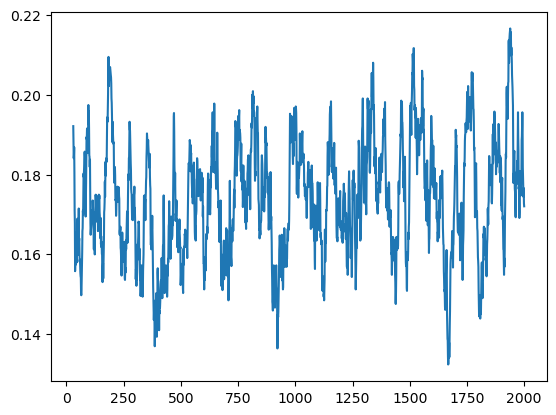

In [18]:
plt.plot(smooth_freq)

Text(0.0, 1.0, 'Evolution of the 30-year averaged PT frequency\nin the 4xCO2 CESM2 run')

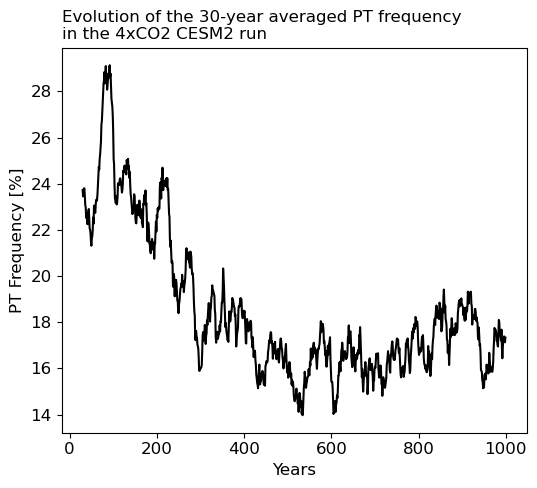

In [19]:
plt.figure(figsize=(6,5))
plt.plot(smooth_freq_4xco2*100,color='k')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('PT Frequency [%]',fontsize=12)
plt.xlabel('Years',fontsize=12)
plt.title('Evolution of the 30-year averaged PT frequency\nin the 4xCO2 CESM2 run',loc='left')
# plt.savefig('Figures/Sup_PTFreq_4xCO2.png')

(array([ 80., 309., 253., 101.,  43.,  63.,  74.,  19.,   8.,  20.]),
 array([0.13972603, 0.15488584, 0.17004566, 0.18520548, 0.2003653 ,
        0.21552511, 0.23068493, 0.24584475, 0.26100457, 0.27616438,
        0.2913242 ]),
 <BarContainer object of 10 artists>)

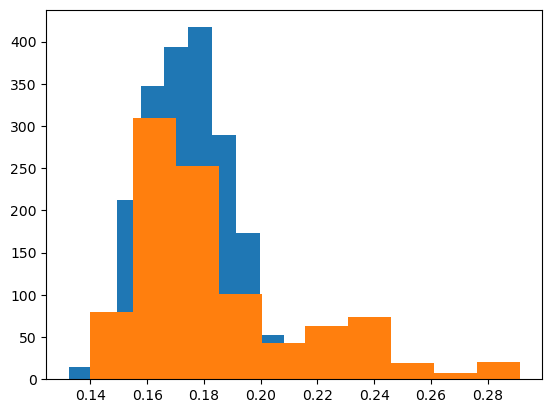

In [20]:
plt.hist(smooth_freq.dropna())
plt.hist(smooth_freq_4xco2.dropna())

# Read difference Z500

In [21]:
diff_z500_4xco2 = xr.open_dataset('../ProcessModelsSurface/diffs_4xco2_surface/4xco2_diffs_z500.nc')
diff_z500_4xco2 = diff_z500_4xco2.sel(time=slice('0001','0200'))
mean_diff_z500_4xco2 = diff_z500_4xco2.mean('time')

In [22]:
mean_area_z500_4xco2 = get_weighted_area_average(mean_diff_z500_4xco2.zg)
std_area_z500_4xco2 = get_weighted_area_average(mean_diff_z500_4xco2.zg)

## Hot days

In [23]:
diffs_p90 = xr.open_dataset('../ProcessModelsSurface/diffs_models_extremes_v2/diffs_lens_higherthanp90.nc')

In [24]:
total_diff_seasonal_p90 = (diffs_p90.b_PT + diffs_p90.b_nonPT).mean('exp')
total_diff_seasonal_percent_p90 = ((diffs_p90.b_PT + diffs_p90.b_nonPT)/diffs_p90.Np).mean('exp')
diff_seasonal_from_pt_p90 = (diffs_p90.a4 + diffs_p90.a5 + diffs_p90.a6).mean('exp')
# diff_seasonal_from_pt_p90 = (diffs_p90.a3).mean('exp')

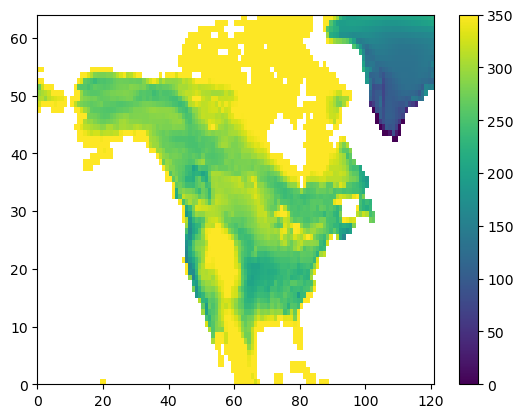

In [25]:
plt.pcolormesh(100*total_diff_seasonal_percent_p90,vmin=0,vmax=350)
plt.colorbar()

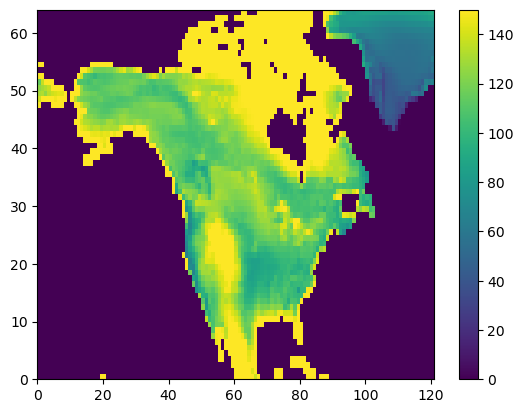

In [26]:
plt.pcolormesh(total_diff_seasonal_p90,vmin=0,vmax=150)
plt.colorbar()

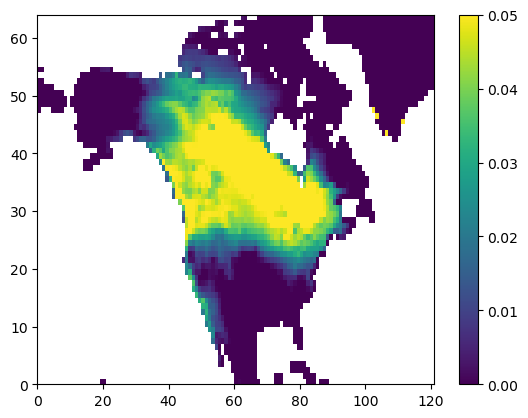

In [27]:
plt.pcolormesh(diff_seasonal_from_pt_p90/total_diff_seasonal_p90,vmin=0,vmax=0.05)
plt.colorbar()

## Hot spells

In [28]:
diffs_ws = xr.open_dataset('../ProcessModelsSurface/diffs_models_extremes_v2/diffs_lens_ws.nc')

In [29]:
total_diff_seasonal_ws = (diffs_ws.b_PT + diffs_ws.b_nonPT).mean('exp')
total_diff_seasonal_percent_ws = ((diffs_ws.b_PT + diffs_ws.b_nonPT)/diffs_ws.Np).mean('exp')
diff_seasonal_from_pt_ws = (diffs_ws.a4 + diffs_ws.a5 + diffs_ws.a6).mean('exp')
# diff_seasonal_from_pt_ws = (diffs_ws.a3).mean('exp')

In [30]:
total_diff_seasonal_ws = (diffs_ws.Nf - diffs_ws.Np).mean('exp')


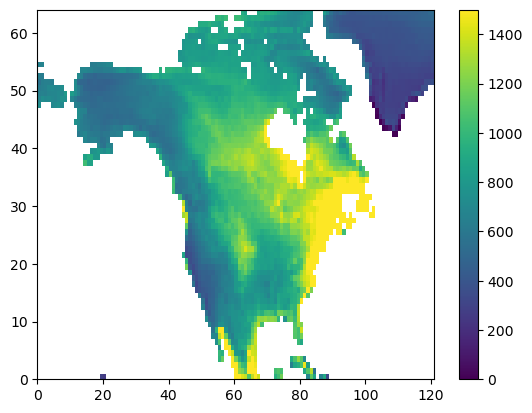

In [31]:
plt.pcolormesh(100*total_diff_seasonal_percent_ws,vmin=0,vmax=1500)
plt.colorbar()

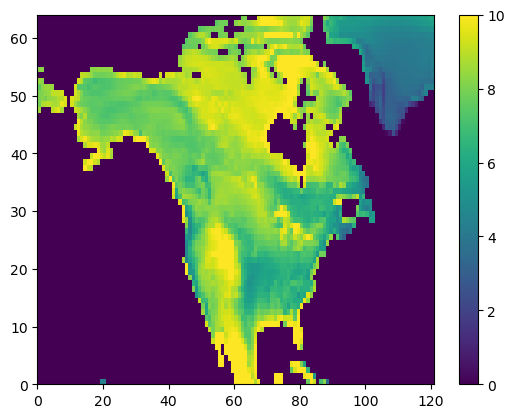

In [32]:
plt.pcolormesh(total_diff_seasonal_ws,vmin=0,vmax=10)
plt.colorbar()

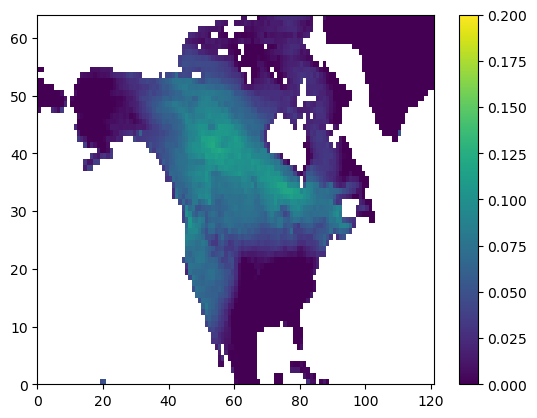

In [33]:
plt.pcolormesh(diff_seasonal_from_pt_ws/total_diff_seasonal_ws,vmin=0,vmax=0.2)
plt.colorbar()

In [34]:
corrs_p90 = xr.open_dataset('../ProcessModelsSurface/corrs_models_extremes/corrs_percent_lens_higherthanp90.nc')
corrs_ws = xr.open_dataset('../ProcessModelsSurface/corrs_models_extremes/corrs_percent_lens_ws.nc')

/glade/derecho/scratch/jhayron/tmp/ipykernel_104148/1534911180.py:73: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(3, 4, 5, projection=ccrs.AlbersEqualArea(
/glade/derecho/scratch/jhayron/tmp/ipykernel_104148/1534911180.py:113: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(3, 4, 6, projection=ccrs.AlbersEqualArea(
/glade/derecho/scratch/jhayron/tmp/ipykernel_104148/1534911180.py:152: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(3, 4, 7, projection=ccrs.AlbersEqualArea(
/glade/derecho/scratch/jhayron/tmp/ipykernel_104148/1534911180.py:190: MatplotlibDeprecat

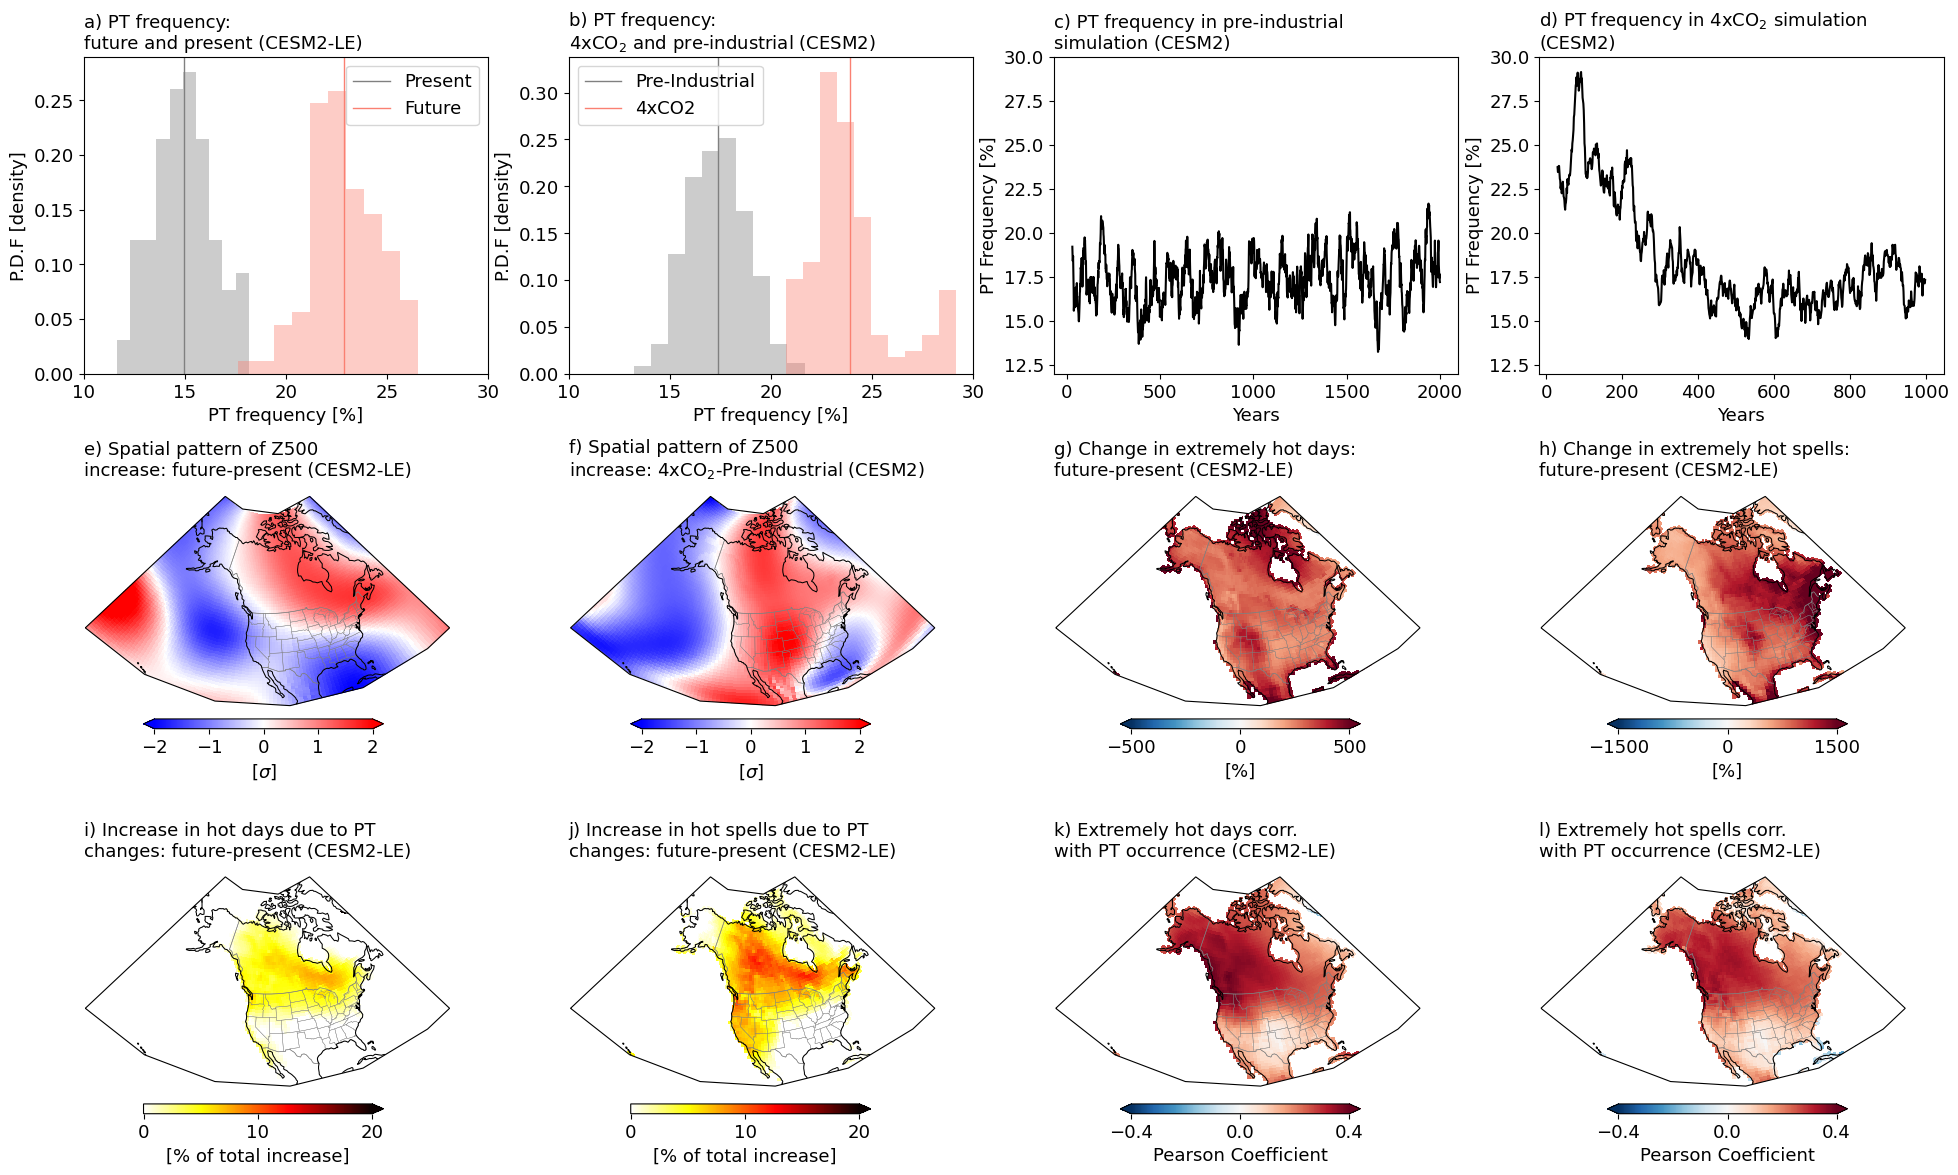

In [36]:
fontsize_most_things = 13
fontsize = fontsize_most_things

fig, axs = plt.subplots(3, 4, figsize=(24, 14))

axs_list = axs.flatten().tolist()
extent = [-180, -50, 20, 80]
# Create a rectangular boundary matching the extent
verts = [
    (extent[0], extent[2]),  # Bottom-left corner
    (extent[1], extent[2]),  # Bottom-right corner
    (extent[1], extent[3]),  # Top-right corner
    (extent[0], extent[3]),  # Top-left corner
    (extent[0], extent[2])   # Closing the rectangle
]

#### Trend in frequency of the PT ####

ax = axs_list[0]

ax.hist(freqs_lens_present*100,color='gray',alpha=0.4,bins=10,density=True)
ax.hist(freqs_lens_future*100,color='salmon',alpha=0.4,bins=10,density=True)
ax.axvline(np.mean(freqs_lens_present)*100,lw=1,color='gray',label='Present')
ax.axvline(np.mean(freqs_lens_future)*100,lw=1,color='salmon',label='Future')
ax.set_xlim(10,30)
ax.set_xlabel('PT frequency [%]\n',fontsize=fontsize)
ax.set_ylabel('P.D.F [density]',fontsize=fontsize)
ax.set_title('a) PT frequency:\nfuture and present (CESM2-LE)',loc='left',fontsize=fontsize)
ax.legend(fontsize=fontsize_most_things)
ax.tick_params(labelsize=fontsize_most_things)

#### Trend in frequency of the PT 4xCO2 ####

ax = axs_list[1]

ax.hist(smooth_freq.dropna()*100,color='gray',alpha=0.4,bins=10,density=True)
ax.hist(smooth_freq_4xco2.dropna()[:200]*100,color='salmon',alpha=0.4,bins=10,density=True)
ax.axvline(np.mean(smooth_freq.dropna())*100,lw=1,color='gray',label='Pre-Industrial')
ax.axvline(np.mean(smooth_freq_4xco2.dropna()[:200])*100,lw=1,color='salmon',label='4xCO2')
ax.set_xlim(10,30)
ax.set_xlabel('PT frequency [%]\n',fontsize=fontsize)
ax.set_ylabel('P.D.F [density]',fontsize=fontsize)
ax.set_title('b) PT frequency:\n4xCO$_2$ and pre-industrial (CESM2)',loc='left',fontsize=fontsize)
ax.legend(fontsize=fontsize_most_things)
ax.tick_params(labelsize=fontsize_most_things)

###### Plot time series of PT freq for pre-industrial #####

ax = axs_list[2]
ax.plot(smooth_freq*100,color='k')
ax.set_ylim(12,30)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
ax.set_ylabel('PT Frequency [%]',fontsize=fontsize)
ax.set_xlabel('Years',fontsize=fontsize)
ax.set_title('c) PT frequency in pre-industrial\nsimulation (CESM2)',fontsize=fontsize,loc='left')
ax.tick_params(labelsize=fontsize_most_things)

###### Plot time series of PT freq for 4xCO2 #####

ax = axs_list[3]
ax.plot(smooth_freq_4xco2*100,color='k')
ax.set_ylim(12,30)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
ax.set_ylabel('PT Frequency [%]',fontsize=fontsize)
ax.set_xlabel('Years',fontsize=fontsize)
ax.set_title('d) PT frequency in 4xCO$_{2}$ simulation\n(CESM2)',fontsize=fontsize,loc='left')
ax.tick_params(labelsize=fontsize_most_things)

# ################# PLOT Z500 diff ######################

ax = plt.subplot(3, 4, 5, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-2
maxi=2
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(mean_diff_z500.lon, 
        mean_diff_z500.lat, 
        # mean_diff_z500.Z_anom,
        # (mean_diff_z500.Z_anom  - mean_area_z500)/std_area_z500,
        (mean_diff_z500.Z_anom  - mean_diff_z500.Z_anom.mean('lon'))/mean_diff_z500.Z_anom.std('lon'),
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='bwr')

ax.set_title(
    f'e) Spatial pattern of Z500\nincrease: future-present (CESM2-LE)', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.125+0.025, 0.4, 0.1, 0.007])#0.317,0.1
ticks_1 = [-2, -1, 0, 1, 2]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[$\sigma$]', fontsize=fontsize_most_things)

################## PLOT Z500 diff ######################

ax = plt.subplot(3, 4, 6, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-2
maxi=2
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(mean_diff_z500_4xco2.lon, 
        mean_diff_z500_4xco2.lat, 
        # (mean_diff_z500_4xco2.zg  - mean_area_z500_4xco2)/std_area_z500_4xco2,
        (mean_diff_z500_4xco2.zg  - mean_diff_z500_4xco2.zg.mean('lon'))/mean_diff_z500_4xco2.zg.std('lon'),
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='bwr')

ax.set_title(
    f'f) Spatial pattern of Z500\nincrease: 4xCO$_2$-Pre-Industrial (CESM2)', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.328+0.025, 0.4, 0.1, 0.007])
ticks_1 = [-2,-1, 0,1,2]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[$\sigma$]', fontsize=fontsize_most_things)

################## PLOT Hot days diff ######################

ax = plt.subplot(3, 4, 7, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-500
maxi=500
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(total_diff_seasonal_percent_p90.lon, 
        total_diff_seasonal_percent_p90.lat, 
        total_diff_seasonal_percent_p90*100,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='RdBu_r')

ax.set_title(
    f'g) Change in extremely hot days:\nfuture-present (CESM2-LE)', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.532+0.025, 0.4, 0.1, 0.007])
ticks_1 = [-500, 0, 500]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[%]', fontsize=fontsize_most_things)

# ################## PLOT Warm spells diff ######################

ax = plt.subplot(3, 4, 8, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-1500
maxi=1500
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(total_diff_seasonal_percent_ws.lon, 
        total_diff_seasonal_percent_ws.lat, 
        total_diff_seasonal_percent_ws*100,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='RdBu_r')

ax.set_title(
    f'h) Change in extremely hot spells:\nfuture-present (CESM2-LE)', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.76, 0.4, 0.1, 0.007])
ticks_1 = [-1500, 0, 1500]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[%]', fontsize=fontsize_most_things)

################## PLOT Hot days PT diff ######################

ax = plt.subplot(3, 4, 9, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=0
maxi=20
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(diff_seasonal_from_pt_p90.lon, 
        diff_seasonal_from_pt_p90.lat, 
        100*diff_seasonal_from_pt_p90/total_diff_seasonal_p90,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='hot_r')

ax.set_title(
    f'i) Increase in hot days due to PT\nchanges: future-present (CESM2-LE)', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.125+0.025, 0.125, 0.1, 0.007])
ticks_1 = [0,10,20]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='max')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[% of total increase]', fontsize=fontsize_most_things)

# ################## PLOT Hot days PT diff ######################

ax = plt.subplot(3, 4, 10, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=0
maxi=20
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(diff_seasonal_from_pt_ws.lon, 
        diff_seasonal_from_pt_ws.lat, 
        100*diff_seasonal_from_pt_ws/total_diff_seasonal_ws,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='hot_r')

ax.set_title(
    f'j) Increase in hot spells due to PT\nchanges: future-present (CESM2-LE)',  
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.328+0.025, 0.125, 0.1, 0.007])
ticks_1 = [0,10,20]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='max')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[% of total increase]', fontsize=fontsize_most_things)

# ################## PLOT Hot days corr ######################

ax = plt.subplot(3, 4, 11, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-0.4
maxi=0.4
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(corrs_p90.lon, 
        corrs_p90.lat, 
        corrs_p90.correlation.mean('exp'),
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='RdBu_r')

ax.set_title(
    f'k) Extremely hot days corr.\nwith PT occurrence (CESM2-LE)', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.532+0.025, 0.125, 0.1, 0.007])
ticks_1 = [-0.4, 0,0.4]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('Pearson Coefficient', fontsize=fontsize_most_things)

# ################## PLOT Hot spells corr ######################

ax = plt.subplot(3, 4, 12, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-0.4
maxi=0.4
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(corrs_p90.lon, 
        corrs_p90.lat, 
        corrs_ws.correlation.mean('exp'),
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='RdBu_r')

ax.set_title(
    f'l) Extremely hot spells corr.\nwith PT occurrence (CESM2-LE)', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.76, 0.125, 0.1, 0.007])
ticks_1 = [-0.4, 0,0.4]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('Pearson Coefficient', fontsize=fontsize_most_things)

# plt.tight_layout()
plt.savefig('nFigures/ChangesModels_IncreasedCO2_v2.pdf',bbox_inches='tight')

/glade/derecho/scratch/jhayron/tmp/ipykernel_104148/1740711774.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1, 2, 1, projection=ccrs.AlbersEqualArea(
/glade/derecho/scratch/jhayron/tmp/ipykernel_104148/1740711774.py:60: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1, 2, 2, projection=ccrs.AlbersEqualArea(


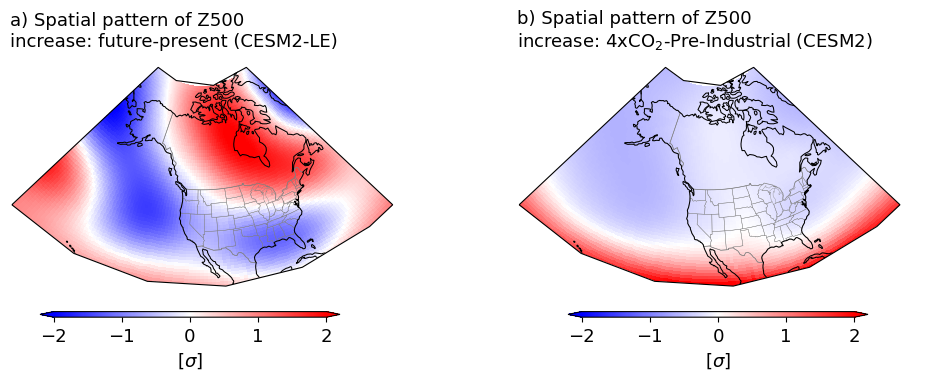

In [37]:
fontsize_most_things = 13
fontsize = fontsize_most_things

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs_list = axs.flatten().tolist()
extent = [-180, -50, 20, 80]
# Create a rectangular boundary matching the extent
verts = [
    (extent[0], extent[2]),  # Bottom-left corner
    (extent[1], extent[2]),  # Bottom-right corner
    (extent[1], extent[3]),  # Top-right corner
    (extent[0], extent[3]),  # Top-left corner
    (extent[0], extent[2])   # Closing the rectangle
]


# ################# PLOT Z500 diff ######################

ax = plt.subplot(1, 2, 1, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-2
maxi=2
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(mean_diff_z500.lon, 
        mean_diff_z500.lat, 
        # mean_diff_z500.Z_anom,
        (mean_diff_z500.Z_anom  - mean_area_z500)/std_area_z500,
        # (mean_diff_z500.Z_anom  - mean_diff_z500.Z_anom.mean('lon'))/mean_diff_z500.Z_anom.std('lon'),
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='bwr')

ax.set_title(
    f'a) Spatial pattern of Z500\nincrease: future-present (CESM2-LE)', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.15, 0.13, 0.25, 0.014])#0.317,0.1
ticks_1 = [-2, -1, 0, 1, 2]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[$\sigma$]', fontsize=fontsize_most_things)

################## PLOT Z500 diff ######################

ax = plt.subplot(1, 2, 2, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-2
maxi=2
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(mean_diff_z500_4xco2.lon, 
        mean_diff_z500_4xco2.lat, 
        (mean_diff_z500_4xco2.zg  - mean_area_z500_4xco2)/std_area_z500_4xco2,
        # (mean_diff_z500_4xco2.zg  - mean_diff_z500_4xco2.zg.mean('lon'))/mean_diff_z500_4xco2.zg.std('lon'),
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='bwr')

ax.set_title(
    f'b) Spatial pattern of Z500\nincrease: 4xCO$_2$-Pre-Industrial (CESM2)', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.59, 0.13, 0.25, 0.014])#0.317,0.1
ticks_1 = [-2, -1, 0, 1, 2]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[$\sigma$]', fontsize=fontsize_most_things)

plt.savefig('nFigures/FigKatie.png',bbox_inches='tight')

# Figure for E3SM2

In [38]:
diff_z500 = xr.open_dataset('../ProcessZ500/diffs_z500_model/e3smv2_diffs_z500.nc')
mean_diff_z500 = diff_z500.mean('exp')

In [39]:
mean_area_z500 = get_weighted_area_average(mean_diff_z500.Z_anom)
std_area_z500 = get_weighted_std(mean_diff_z500.Z_anom)

In [40]:
files_e3smv2 = np.sort(glob.glob('../ProcessZ500/labels_e3smv2/*.csv'))

dic_labels_e3smv2 = {}

for file_temp in files_e3smv2:
    labels_temp = pd.read_csv(file_temp, parse_dates=True, index_col=0, 
                              names=['WR','distances','corr'], skiprows=1)#[['WR']]
    labels_temp['season'] = labels_temp.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    labels_temp['season'] = labels_temp['season'].map(season_map)
    labels_temp.loc[labels_temp['corr']<=0.2,'WR']=np.unique(labels_temp['WR'])[-1]
    dic_labels_e3smv2[file_temp.split('labels_')[-1][:-4]] = labels_temp

dic_events_e3smv2 = {}

for file_temp in files_e3smv2:
    # Compute Overall Frequency of Each Class
    df_labels = copy.deepcopy(dic_labels_e3smv2[file_temp.split('labels_')[-1][:-4]])

    # Step 1: Identify changes in class to find the start of each event
    df_labels['shifted'] = df_labels['WR'].shift(1)
    df_labels['start'] = df_labels['WR'] != df_labels['shifted']
    df_labels['start_date'] = df_labels.index.where(df_labels['start'], pd.NaT)
    df_labels['start_date'].fillna(method='ffill', inplace=True)
    
    # Step 2: Calculate the duration of each event
    # Convert the Timedelta to its 'days' component
    df_labels['duration'] = (df_labels.index - df_labels['start_date']).dt.days + 1
    
    # Step 3: Create the df_events DataFrame
    # Group by 'start_date' and 'class' to get the duration of each class event
    df_events = df_labels.groupby(['start_date', 'WR']).agg({'duration': 'max','corr':'mean','distances':'mean'}).reset_index()
    
    # Drop the temporary columns used for calculations
    df_labels.drop(columns=['shifted', 'start', 'start_date', 'duration'], inplace=True)
    
    # Set 'start_date' as the index if needed
    df_events.set_index('start_date', inplace=True)
    df_events['season'] = df_events.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    df_events['season'] = df_events['season'].map(season_map)
    df_events['year'] = df_events.index.year
    # df_events = df_events[df_events['duration']>=4]
    dic_events_e3smv2[file_temp.split('labels_')[-1][:-4]] = df_events

/glade/derecho/scratch/jhayron/tmp/ipykernel_104148/1954339532.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_labels['start_date'].fillna(method='ffill', inplace=True)
/glade/derecho/scratch/jhayron/tmp/ipykernel_104148/1954339532.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_labels['start_date'].fillna(method='ffill', inplace=True)
/glade/derecho/scratch/jhayron/tmp/ipykernel_104148/1954339532.py:25: FutureWarning: A va

In [41]:
N=30

In [42]:
from multiprocessing import Pool

# Function to process each file and return results
def process_file(file_temp):
    print(file_temp)
    key = file_temp.split('labels_')[-1][:-4]
    dic_stats = {}
    dic_dfs = {}

    start_year = dic_labels_e3smv2[key].index.year[0] + (N-1)
    end_year = dic_labels_e3smv2[key].index.year[-1]
    
    for wr in range(6):
        df_temp = copy.deepcopy(dic_events_e3smv2[key])
        df_temp = df_temp[(df_temp['season'] == 'Winter')|(df_temp['season'] == 'Spring')]
        df_temp = df_temp[df_temp['WR'] == wr]
        
        dic_stats_temp = {
            'mean': [],
            'std': [],
            'p90': [],
            'p10': [],
            'p95': [],
            'p05': [],
            'n_events': [],
            'n_days': []
        }
        
        for year in range(start_year, end_year + 1):
            df_temp_temp = df_temp.loc[str(year-N+1):str(year)]['duration']
            dic_stats_temp['mean'].append(df_temp_temp.mean())
            dic_stats_temp['std'].append(df_temp_temp.std())
            dic_stats_temp['p90'].append(df_temp_temp.quantile(0.9))
            dic_stats_temp['p10'].append(df_temp_temp.quantile(0.1))
            dic_stats_temp['p95'].append(df_temp_temp.quantile(0.95))
            dic_stats_temp['p05'].append(df_temp_temp.quantile(0.05))

            dic_stats_temp['n_events'].append(len(df_temp_temp) / 30)
            dic_stats_temp['n_days'].append(df_temp_temp.sum() / (30 * 365 / 2))
        
        df_stats_temp = pd.DataFrame(dic_stats_temp, index=np.arange(start_year, end_year + 1))
        dic_stats[f'wr{wr}'] = df_stats_temp
        dic_dfs[f'wr{wr}'] = df_temp
    
    return key, dic_stats, dic_dfs

# Use multiprocessing to parallelize the processing
if __name__ == '__main__':
    dic_stats_durations_e3smv2 = {}
    dic_dfs_durations_e3smv2 = {}

    with Pool() as pool:
        results = pool.map(process_file, files_e3smv2)

    # Collect results into the final dictionaries
    for key, dic_stats, dic_dfs in results:
        dic_stats_durations_e3smv2[key] = dic_stats
        dic_dfs_durations_e3smv2[key] = dic_dfs

    # You can now use dic_stats_durations_lens2 and dic_dfs_durations_lens2 as needed

../ProcessZ500/labels_e3smv2/df_labels_cmip6_0111.csv../ProcessZ500/labels_e3smv2/df_labels_cmip6_0121.csv../ProcessZ500/labels_e3smv2/df_labels_cmip6_0131.csv../ProcessZ500/labels_e3smv2/df_labels_cmip6_0141.csv../ProcessZ500/labels_e3smv2/df_labels_cmip6_0171.csv../ProcessZ500/labels_e3smv2/df_labels_cmip6_0161.csv../ProcessZ500/labels_e3smv2/df_labels_cmip6_0181.csv../ProcessZ500/labels_e3smv2/df_labels_cmip6_0191.csv../ProcessZ500/labels_e3smv2/df_labels_cmip6_0221.csv
../ProcessZ500/labels_e3smv2/df_labels_cmip6_0211.csv
../ProcessZ500/labels_e3smv2/df_labels_cmip6_0231.csv../ProcessZ500/labels_e3smv2/df_labels_cmip6_0261.csv../ProcessZ500/labels_e3smv2/df_labels_cmip6_0271.csv../ProcessZ500/labels_e3smv2/df_labels_cmip6_0241.csv
../ProcessZ500/labels_e3smv2/df_labels_cmip6_0281.csv
../ProcessZ500/labels_e3smv2/df_labels_cmip6_0291.csv../ProcessZ500/labels_e3smv2/df_labels_smbb_0101.csv
../ProcessZ500/labels_e3smv2/df_labels_smbb_0111.csv

../ProcessZ500/labels_e3smv2/df_labels_sm

In [43]:
names_models = np.array([file_temp.split('labels_')[-1][:-4] for file_temp in files_e3smv2])

In [44]:
wr = 1
freqs_e3smv2_present = []
freqs_e3smv2_future = []

start_year = 1994
end_year = 2023

end_year_future = 2100
start_year_future = end_year_future - (end_year-start_year)
print(start_year_future)

for name_temp in names_models:
    df_stats_temp = dic_stats_durations_e3smv2[name_temp][f'wr{wr}']
    try:
        freqs_e3smv2_future.append(df_stats_temp['n_days'][end_year_future])
        freqs_e3smv2_present.append(df_stats_temp['n_days'][end_year])
    except:
        pass
freqs_e3smv2_present = np.array(freqs_e3smv2_present)
freqs_e3smv2_future = np.array(freqs_e3smv2_future)

2071


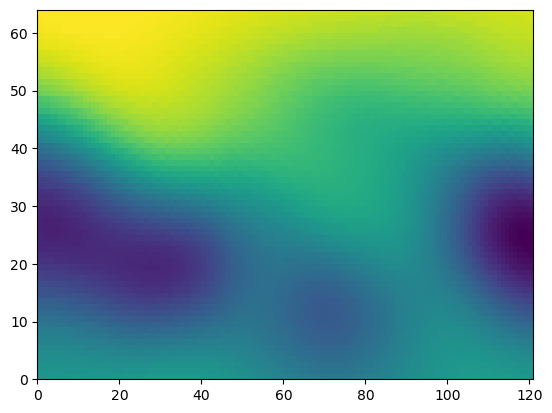

In [45]:
plt.pcolormesh(mean_diff_z500.Z_anom)

/glade/derecho/scratch/jhayron/tmp/ipykernel_104148/3881120676.py:36: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1, 2, 2, projection=ccrs.AlbersEqualArea(


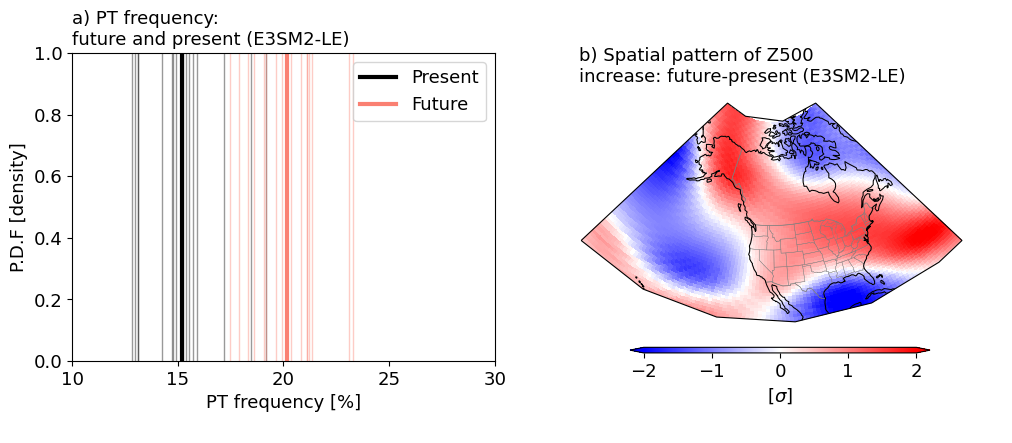

In [47]:
fontsize_most_things = 13
fontsize = fontsize_most_things

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs_list = axs.flatten().tolist()
extent = [-180, -50, 20, 80]
# Create a rectangular boundary matching the extent
verts = [
    (extent[0], extent[2]),  # Bottom-left corner
    (extent[1], extent[2]),  # Bottom-right corner
    (extent[1], extent[3]),  # Top-right corner
    (extent[0], extent[3]),  # Top-left corner
    (extent[0], extent[2])   # Closing the rectangle
]

#### Trend in frequency of the PT ####

ax = axs_list[0]

for i in range(len(freqs_e3smv2_present)):
    ax.axvline(freqs_e3smv2_present[i]*100,color='k',alpha=0.4,lw=1)
    ax.axvline(freqs_e3smv2_future[i]*100,color='salmon',alpha=0.4,lw=1)

ax.axvline(np.mean(freqs_e3smv2_present)*100,color='k',label='Present',lw=3)
ax.axvline(np.mean(freqs_e3smv2_future)*100,color='salmon',label='Future',lw=3)
ax.set_xlim(10,30)
ax.set_xlabel('PT frequency [%]\n',fontsize=fontsize)
ax.set_ylabel('P.D.F [density]',fontsize=fontsize)
ax.set_title('a) PT frequency:\nfuture and present (E3SM2-LE)',loc='left',fontsize=fontsize)
ax.legend(fontsize=fontsize_most_things)
ax.tick_params(labelsize=fontsize_most_things)

# ################# PLOT Z500 diff ######################

ax = plt.subplot(1, 2, 2, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-2
maxi=2
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(mean_diff_z500.lon, 
        mean_diff_z500.lat, 
        # mean_diff_z500.Z_anom,
        # (mean_diff_z500.Z_anom  - mean_area_z500)/std_area_z500,
        (mean_diff_z500.Z_anom  - mean_diff_z500.Z_anom.mean('lon'))/mean_diff_z500.Z_anom.std('lon'),
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='bwr')

ax.set_title(
    f'b) Spatial pattern of Z500\nincrease: future-present (E3SM2-LE)', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.59, 0.13, 0.25, 0.014])#0.317,0.1
ticks_1 = [-2, -1, 0, 1, 2]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[$\sigma$]', fontsize=fontsize_most_things)
plt.savefig('nFigures/Sup_E3SM2_Future.png',bbox_inches='tight')


In [46]:
aaaaaa

NameError: name 'aaaaaa' is not defined

In [ ]:
fontsize_most_things = 13
fontsize = fontsize_most_things

fig, axs = plt.subplots(3, 4, figsize=(24, 14))

axs_list = axs.flatten().tolist()
extent = [-180, -50, 20, 80]
# Create a rectangular boundary matching the extent
verts = [
    (extent[0], extent[2]),  # Bottom-left corner
    (extent[1], extent[2]),  # Bottom-right corner
    (extent[1], extent[3]),  # Top-right corner
    (extent[0], extent[3]),  # Top-left corner
    (extent[0], extent[2])   # Closing the rectangle
]

#### Trend in frequency of the PT ####

ax = axs_list[0]

ax.hist(freqs_lens_present*100,color='gray',alpha=0.4,bins=10,density=True)
ax.hist(freqs_lens_future*100,color='salmon',alpha=0.4,bins=10,density=True)
ax.axvline(np.mean(freqs_lens_present)*100,lw=1,color='gray',label='Present')
ax.axvline(np.mean(freqs_lens_future)*100,lw=1,color='salmon',label='Future')
ax.set_xlim(10,30)
ax.set_xlabel('PT frequency [%]\n',fontsize=fontsize)
ax.set_ylabel('P.D.F [density]',fontsize=fontsize)
ax.set_title('a) w-s PT frequency:\nfuture and present (CESM2-LE)',loc='left',fontsize=fontsize)
ax.legend(fontsize=fontsize_most_things)
ax.tick_params(labelsize=fontsize_most_things)

#### Trend in frequency of the PT 4xCO2 ####

ax = axs_list[1]

ax.hist(smooth_freq.dropna()*100,color='gray',alpha=0.4,bins=10,density=True)
ax.hist(smooth_freq_4xco2.dropna()[:200]*100,color='salmon',alpha=0.4,bins=10,density=True)
ax.axvline(np.mean(smooth_freq.dropna())*100,lw=1,color='gray',label='Pre-Industrial')
ax.axvline(np.mean(smooth_freq_4xco2.dropna()[:200])*100,lw=1,color='salmon',label='4xCO2')
ax.set_xlim(10,30)
ax.set_xlabel('PT frequency [%]\n',fontsize=fontsize)
ax.set_ylabel('P.D.F [density]',fontsize=fontsize)
ax.set_title('b) w-s PT frequency:\n4xCO$_2$ and pre-industrial (CESM2)',loc='left',fontsize=fontsize)
ax.legend(fontsize=fontsize_most_things)
ax.tick_params(labelsize=fontsize_most_things)

###### Plot time series of PT freq for pre-industrial #####

ax = axs_list[2]
ax.plot(smooth_freq*100,color='k')
ax.set_ylim(12,30)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
ax.set_ylabel('PT Frequency [%]',fontsize=fontsize)
ax.set_xlabel('Years',fontsize=fontsize)
ax.set_title('c) w-s PT frequency in pre-industrial\nsimulation (CESM2)',fontsize=fontsize,loc='left')
ax.tick_params(labelsize=fontsize_most_things)

###### Plot time series of PT freq for 4xCO2 #####

ax = axs_list[3]
ax.plot(smooth_freq_4xco2*100,color='k')
ax.set_ylim(12,30)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
ax.set_ylabel('PT Frequency [%]',fontsize=fontsize)
ax.set_xlabel('Years',fontsize=fontsize)
ax.set_title('d) w-s PT frequency in 4xCO$_{2}$ simulation\n(CESM2)',fontsize=fontsize,loc='left')
ax.tick_params(labelsize=fontsize_most_things)

# ################# PLOT Z500 diff ######################

ax = plt.subplot(3, 4, 5, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-2
maxi=2
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(mean_diff_z500.lon, 
        mean_diff_z500.lat, 
        mean_diff_z500.Z_anom,
        # (mean_diff_z500.Z_anom  - mean_diff_z500.Z_anom.mean('lon'))/mean_diff_z500.Z_anom.std('lon'),
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='bwr')

ax.set_title(
    f'e) Spatial pattern of w-s Z500\nincrease: future-present (CESM2-LE)', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.125+0.025, 0.4, 0.1, 0.007])#0.317,0.1
ticks_1 = [-2, -1, 0, 1, 2]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[$\sigma$]', fontsize=fontsize_most_things)

################## PLOT Z500 diff ######################

ax = plt.subplot(3, 4, 6, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-2
maxi=2
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(mean_diff_z500_4xco2.lon, 
        mean_diff_z500_4xco2.lat, 
        mean_diff_z500_4xco2.zg,
        # (mean_diff_z500_4xco2.zg  - mean_diff_z500_4xco2.zg.mean('lon'))/mean_diff_z500_4xco2.zg.std('lon'),
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='bwr')

ax.set_title(
    f'f) Spatial pattern of w-s Z500\nincrease: 4xCO$_2$-Pre-Industrial (CESM2)', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.328+0.025, 0.4, 0.1, 0.007])
ticks_1 = [-2,-1, 0,1,2]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[$\sigma$]', fontsize=fontsize_most_things)

################## PLOT Hot days diff ######################

ax = plt.subplot(3, 4, 7, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-500
maxi=500
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(total_diff_seasonal_percent_p90.lon, 
        total_diff_seasonal_percent_p90.lat, 
        total_diff_seasonal_percent_p90*100,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='RdBu_r')

ax.set_title(
    f'g) w-s change in extremely hot days:\nfuture-present (CESM2-LE)', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.532+0.025, 0.4, 0.1, 0.007])
ticks_1 = [-500, 0, 500]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[%]', fontsize=fontsize_most_things)

# ################## PLOT Warm spells diff ######################

ax = plt.subplot(3, 4, 8, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-1500
maxi=1500
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(total_diff_seasonal_percent_ws.lon, 
        total_diff_seasonal_percent_ws.lat, 
        total_diff_seasonal_percent_ws*100,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='RdBu_r')

ax.set_title(
    f'h) w-s change in extremely hot spells:\nfuture-present (CESM2-LE)', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.76, 0.4, 0.1, 0.007])
ticks_1 = [-1500, 0, 1500]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[%]', fontsize=fontsize_most_things)

################## PLOT Hot days PT diff ######################

ax = plt.subplot(3, 4, 9, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=0
maxi=20
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(diff_seasonal_from_pt_p90.lon, 
        diff_seasonal_from_pt_p90.lat, 
        100*diff_seasonal_from_pt_p90/total_diff_seasonal_p90,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='hot_r')

ax.set_title(
    f'i) w-s increase in hot days due to PT\nchanges: future-present (CESM2-LE)', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.125+0.025, 0.125, 0.1, 0.007])
ticks_1 = [0,10,20]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='max')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[% of total increase]', fontsize=fontsize_most_things)

# ################## PLOT Hot days PT diff ######################

ax = plt.subplot(3, 4, 10, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=0
maxi=20
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(diff_seasonal_from_pt_ws.lon, 
        diff_seasonal_from_pt_ws.lat, 
        100*diff_seasonal_from_pt_ws/total_diff_seasonal_ws,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='hot_r')

ax.set_title(
    f'j) w-s increase in hot spells due to PT\nchanges: future-present (CESM2-LE)',  
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.328+0.025, 0.125, 0.1, 0.007])
ticks_1 = [0,10,20]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='max')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[% of total increase]', fontsize=fontsize_most_things)

# ################## PLOT Hot days corr ######################

ax = plt.subplot(3, 4, 11, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-0.4
maxi=0.4
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(corrs_p90.lon, 
        corrs_p90.lat, 
        corrs_p90.correlation.mean('exp'),
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='RdBu_r')

ax.set_title(
    f'k) Extremely hot days corr.\nwith PT occurrence (CESM2-LE)', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.532+0.025, 0.125, 0.1, 0.007])
ticks_1 = [-0.4, 0,0.4]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('Pearson Coefficient', fontsize=fontsize_most_things)

# ################## PLOT Hot spells corr ######################

ax = plt.subplot(3, 4, 12, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-0.4
maxi=0.4
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(corrs_p90.lon, 
        corrs_p90.lat, 
        corrs_ws.correlation.mean('exp'),
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='RdBu_r')

ax.set_title(
    f'l) Extremely hot spells corr.\nwith PT occurrence (CESM2-LE)', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.76, 0.125, 0.1, 0.007])
ticks_1 = [-0.4, 0,0.4]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('Pearson Coefficient', fontsize=fontsize_most_things)

# plt.tight_layout()
# plt.savefig('nFigures/ChangesModels_IncreasedCO2.pdf',bbox_inches='tight')

In [ ]:
diffs_percent_ws

In [ ]:
plt.pcolormesh(mean_diff_z500_4xco2.zg)
plt.colorbar()

In [ ]:
diffs_percent_p90

In [ ]:
fontsize_most_things = 12
fontsize = fontsize_most_things

fig, axs = plt.subplots(
        2, 4,
        figsize=(15, 6))

axs_list = axs.flatten().tolist()
extent = [-180, -50, 20, 80]
# Create a rectangular boundary matching the extent
verts = [
    (extent[0], extent[2]),  # Bottom-left corner
    (extent[1], extent[2]),  # Bottom-right corner
    (extent[1], extent[3]),  # Top-right corner
    (extent[0], extent[3]),  # Top-left corner
    (extent[0], extent[2])   # Closing the rectangle
]

#### Trend in frequency of the PT ####

ax = axs_list[0]

ax.hist(freqs_lens_present*100,color='gray',alpha=0.4,bins=10,density=True)
ax.hist(freqs_lens_future*100,color='salmon',alpha=0.4,bins=10,density=True)
ax.axvline(np.mean(freqs_lens_present)*100,lw=1,color='gray')
ax.axvline(np.mean(freqs_lens_future)*100,lw=1,color='salmon')
ax.set_xlabel('Diff. in PT frequency [%]\n(1994-2023 vs. 1948-1977)',fontsize=fontsize)
ax.set_ylabel('P.D.F [density]',fontsize=fontsize)
ax.set_title('a) PT Frequency:\nFuture vs. Present',loc='left',fontsize=fontsize)


# ################# PLOT Z500 diff ######################

ax = plt.subplot(2, 4, 2, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-2
maxi=2
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(mean_diff_z500.lon, 
        mean_diff_z500.lat, 
        (mean_diff_z500.Z_anom  - mean_diff_z500.Z_anom.mean('lon'))/mean_diff_z500.Z_anom.std('lon'),
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='bwr')

ax.set_title(
    f'b) Zonally Standardized 500hPa Geop.\nHeight Diff.: Future vs. Present', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.317, 0.58, 0.15, 0.007])
ticks_1 = [-2,-1, 0,1,2]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[$\sigma$]', fontsize=fontsize_most_things)

# ################# PLOT Tmax diff ######################

ax = plt.subplot(2, 4, 3, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-2
maxi=2
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(mean_diff_tmax.lon, 
        mean_diff_tmax.lat, 
        (mean_diff_tmax.TREFHTMX  - mean_diff_tmax.TREFHTMX.mean('lon'))/mean_diff_tmax.TREFHTMX.std('lon'),
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='seismic')

ax.set_title(
    f'c) Zonally Standardized Max. Temp.\nDiff.: Future - Present', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.56, 0.58, 0.15, 0.007])
ticks_1 = [-2,-1, 0,1,2]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[$\sigma$]', fontsize=fontsize_most_things)

# ################# PLOT Precip diff ######################

ax = plt.subplot(2, 4, 4, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-2
maxi=2
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(mean_diff_precip.lon, 
        mean_diff_precip.lat, 
        (mean_diff_precip.PRECT - mean_diff_precip.PRECT.mean('lon'))/mean_diff_precip.PRECT.std('lon'),
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='BrBG')

ax.set_title(
    f'd) Zonally Standardized Precipitation\nDiff.: Future - Present', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.8, 0.58, 0.15, 0.007])
ticks_1 = [-2,-1, 0,1,2]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[$\sigma$]', fontsize=fontsize_most_things)

#### Trend in frequency of the PT 4xCO2 ####

ax = axs_list[4]

ax.hist(smooth_freq.dropna()*100,color='gray',alpha=0.4,bins=10,density=True)
ax.hist(smooth_freq_4xco2.dropna()*100,color='salmon',alpha=0.4,bins=10,density=True)
ax.axvline(np.mean(smooth_freq.dropna())*100,lw=1,color='gray')
ax.axvline(np.mean(smooth_freq_4xco2.dropna())*100,lw=1,color='salmon')
ax.set_xlabel('PT frequency [%]\n',fontsize=fontsize)
ax.set_ylabel('P.D.F [density]',fontsize=fontsize)
ax.set_title('e) PT Frequency:\n4xCO2 vs. pre-industrial',loc='left',fontsize=fontsize)

################## PLOT Z500 diff ######################

ax = plt.subplot(2, 4, 6, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-2
maxi=2
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(mean_diff_z500_4xco2.lon, 
        mean_diff_z500_4xco2.lat, 
        (mean_diff_z500_4xco2.zg  - mean_diff_z500_4xco2.zg.mean('lon'))/mean_diff_z500_4xco2.zg.std('lon'),
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='bwr')

ax.set_title(
    f'f) Zonally Standardized 500hPa Geop.\nHeight Diff.: 4xCO2 vs. Pre-Industrial', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.317, 0.1, 0.15, 0.007])
ticks_1 = [-2,-1, 0,1,2]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[$\sigma$]', fontsize=fontsize_most_things)

# ################# PLOT Tmax diff ######################

ax = plt.subplot(2, 4, 7, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-2.
maxi=2.
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(mean_diff_tas_4xco2.lon, 
        mean_diff_tas_4xco2.lat, 
        (mean_diff_tas_4xco2.tas  - mean_diff_tas_4xco2.tas.mean('lon'))/mean_diff_tas_4xco2.tas.std('lon'),
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='seismic')

ax.set_title(
    f'g) Zonally Standardized Temperature\nDiff.: 4xCO2 vs. Pre-Industrial', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.56, 0.1, 0.15, 0.007])
ticks_1 = [-2,-1, 0,1,2]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[$\sigma$]', fontsize=fontsize_most_things)

# ################# PLOT Precip diff ######################

ax = plt.subplot(2, 4, 8, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-2
maxi=2
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(mean_diff_pr_4xco2.lon, 
        mean_diff_pr_4xco2.lat, 
        (mean_diff_pr_4xco2.pr  - mean_diff_pr_4xco2.pr.mean('lon'))/mean_diff_pr_4xco2.pr.std('lon'),
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='BrBG')

ax.set_title(
    f'h) Zonally Standardized Precipitation\nDiff.: 4xCO2 vs. Pre-Industrial', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.8, 0.1, 0.15, 0.007])
ticks_1 = [-2,-1, 0,1,2]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[$\sigma$]', fontsize=fontsize_most_things)

plt.tight_layout()
plt.savefig('Figures/4_Future.png',bbox_inches='tight')

In [ ]:
diff_z500_4xco2.zg